# Trail Descriptions Visualization Notebook

Author: Andrew Auyeung

The contents of this notebook are the visualizations done after the Trail Descriptions are cleaned and have undergone some form of topic modelling. 

### Load Libaries 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nlp_vis
from nlp import NLPPipe
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from itertools import cycle

### Load clean data and models. 

In [3]:
hikes_df = pd.read_csv('../src/clean_all_hikes.csv', index_col=0)
hikes_df.set_index('hike_id', inplace=True) 

# Load Pipe
pipe = NLPPipe()
pipe.load_pipe(filename='../models/nmf_trail_desc.mdl')


In [3]:
nlp_vis.display_topics(pipe.model, pipe.vectorizer.get_feature_names(), 15)


Topic  0
activity option, number activity, offer number, activity, number, option, trail offer, offer, loop, loop trail, traffic loop, moderately traffic, moderately, mile moderately, option well

Topic  1
loop, run, loop trail, hiking, use hiking, loop mile, primarily, primarily use, trail primarily, nature, traffic loop, run nature, trip, nature trip, walk run

Topic  2
well use, well, october dog, october, march, use march, trail must, must kept, kept leash, must, leash, kept, dog, dog also, moderate trail

Topic  3
wild, flower, wild flower, beautiful wild, feature beautiful, beautiful, flower rate, flower good, feature, colorado feature, rate, moderate trail, rate moderate, moderate, trail mile

Topic  4
great forest, feature great, forest set, set, great, forest, set rate, set good, feature, set trail, rate moderate, moderate, rate, trail rate, mile loop

Topic  5
accessible, accessible yearround, yearround, yearround dog, option accessible, trail must, kept leash, kept, must, l

### Use the Pipe to get a Document-Term Matrix and Append the Document-Topic Matrix to the end of the main dataframe (hikes_df)

In [4]:
hikes_dtm = pipe.vectorizer.transform(hikes_df['cleaned_descriptions'])
hikes_df, topics = pipe.topic_transform_df(hikes_df, hikes_dtm, append_max=False)

### Visualize Topic Distribution

In [89]:
# Group by State to see state topic importances. 
topic_dist = hikes_df.groupby('state')[['Topic_0',
 'Topic_1',
 'Topic_2',
 'Topic_3',
 'Topic_4',
 'Topic_5',
 'Topic_6',
 'Topic_7',
 'Topic_8']].sum()

In [91]:
# Get Percentage of total topic distribution
topic_dist = topic_dist.div(topic_dist.sum(axis=1), axis=0)

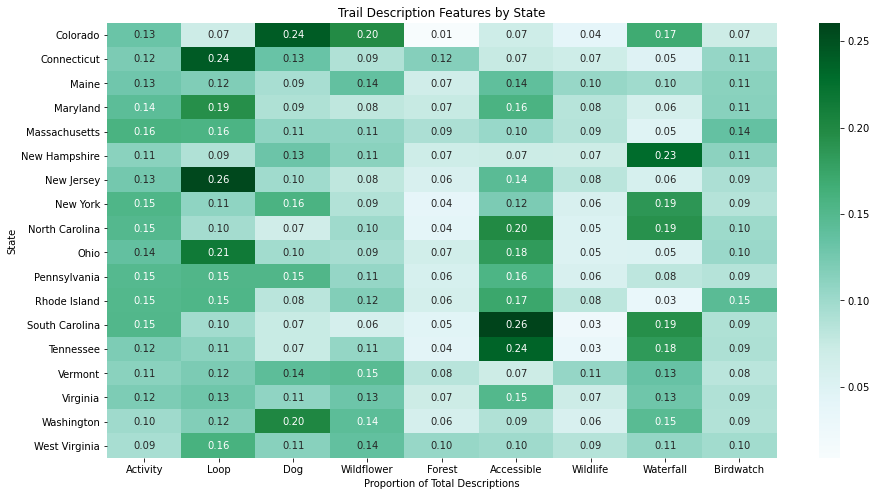

In [106]:
plt.figure(figsize=(15,8))
topic_dist.columns=['Activity', 'Loop', 'Dog', 'Wildflower', 'Forest', 'Accessible', 'Wildlife', 'Waterfall', 'Birdwatch']
sns.heatmap(topic_dist, annot=True, cmap='BuGn', fmt='.2f')
plt.ylabel('State')
plt.xlabel('Proportion of Total Descriptions')
plt.title('Trail Description Features by State');

### Melt Dataframe to stack topic importance in a barchart

In [46]:
topic_dist.reset_index(inplace=True)
topic_dist = topic_dist.melt(id_vars='state')

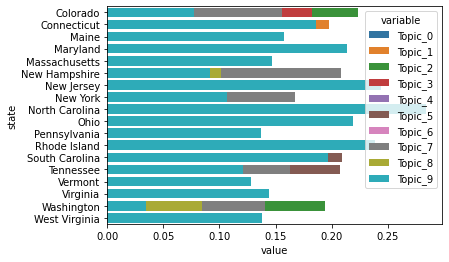

In [56]:
sns.barplot(y='state', x='value', data=topic_dist, hue='variable', dodge=False)

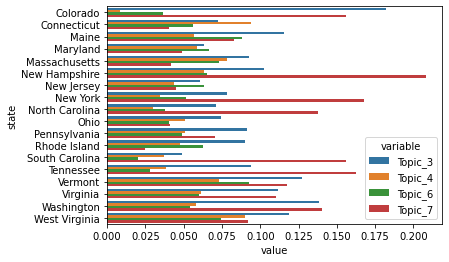

In [57]:
mask = topic_dist['variable'].isin(['Topic_3', 'Topic_4', 'Topic_6', 'Topic_7'])
sns.barplot(y='state', x='value', data=topic_dist[mask], hue='variable')

__Visualizations were hard to use to discern a fast conclusion for audiences.__

### Plot PCA and T-SNe plots to visualize topic separation

The distribution of the topics suggest that there are two bins the topics will fall into:  
* Trail Options
* Trail Features

The two groups in the following will be a seaparation of each to see if the grouping is unique and separable. 

In [55]:
y = np.argmax(hikes_df[['Topic_0',
 'Topic_1',
 'Topic_2',
 'Topic_3',
 'Topic_4',
 'Topic_5',
 'Topic_6',
 'Topic_7',
 'Topic_8']].to_numpy(), axis=1)

In [63]:
# Get Index and labels for Group 1 (Trail Options)
group_1_idx = np.concatenate([np.argwhere(y==0), np.argwhere(y==1), np.argwhere(y==2), np.argwhere(y==5)])
group_1_labels = y[np.concatenate([np.argwhere(y==0), np.argwhere(y==1), np.argwhere(y==2), np.argwhere(y==5)])]

In [117]:
# PCA Fit and Transform document-topic matrix
pca = PCA(2)
group_1_X = pca.fit_transform(hikes_df.iloc[group_1_idx[:,0]][['Topic_0', 'Topic_1', 'Topic_2', 'Topic_5',]])

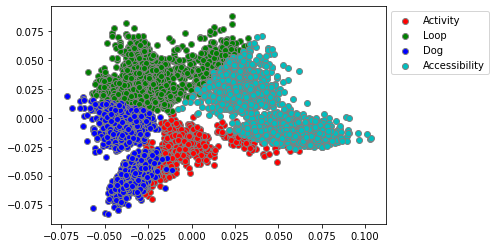

In [118]:
colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
data = group_1_X
target = group_1_labels.reshape(1,-1)[0]
target_names = ['Activity', 'Loop', 'Dog', 'Accessibility']
target_ids = np.unique(target)
plt.figure()
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(data[target == i, 0], data[target == i, 1],
                c=c, label=label, edgecolors='gray', alpha=1)
plt.legend(bbox_to_anchor=(1,1))

In [137]:
# Get Index and labels for Group 2 (Trail Features)
group_2_idx = np.concatenate([np.argwhere(y==3), np.argwhere(y==6), np.argwhere(y==7), np.argwhere(y==8)])
group_2_labels = y[np.concatenate([np.argwhere(y==3), np.argwhere(y==6), np.argwhere(y==7), np.argwhere(y==8)])]


In [ ]:
# Generate PCA to fit and transform the document-topic matrix
pca = PCA(2)
group_2_X = pca.fit_transform(hikes_df.iloc[group_2_idx[:,0]][['Topic_3', 'Topic_6', 'Topic_7', 'Topic_8']])

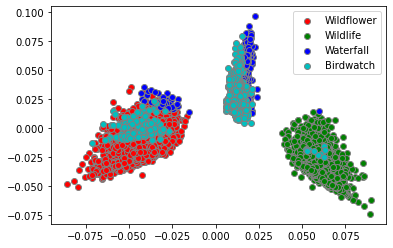

In [138]:
colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
data = group_2_X
target = group_2_labels.reshape(1,-1)[0]
target_names = ['Wildflower', 'Wildlife', 'Waterfall', 'Birdwatch']
target_ids = np.unique(target)
plt.figure()
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(data[target == i, 0], data[target == i, 1],
                c=c, label=label, edgecolors='gray', alpha=1)
plt.legend(bbox_to_anchor=(1,1))

In [140]:
group_2_X

array([[-0.04774087, -0.01550032],
       [-0.04533953, -0.02589263],
       [-0.05215645, -0.02958924],
       ...,
       [ 0.01016952,  0.01987296],
       [ 0.01408057,  0.02730965],
       [ 0.01086634,  0.01399718]])

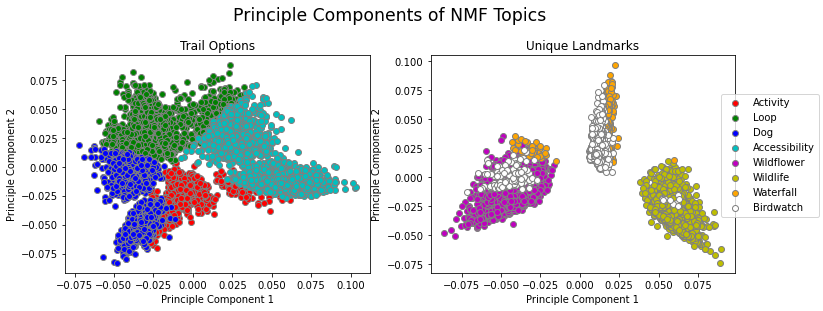

In [201]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])

data = group_1_X
target = group_1_labels.reshape(1,-1)[0]
target_names = ['Activity', 'Loop', 'Dog', 'Accessibility']
target_ids = np.unique(target)
for i, c, label in zip(target_ids, colors, target_names):
    ax[0].scatter(data[target == i, 0], data[target == i, 1],
                c=c, label=label, edgecolors='gray', alpha=1)

data = group_2_X
target = group_2_labels.reshape(1,-1)[0]
target_names = ['Wildflower', 'Wildlife', 'Waterfall', 'Birdwatch']
target_ids = np.unique(target)
for i, c, label in zip(target_ids, colors, target_names):
    ax[1].scatter(data[target == i, 0], data[target == i, 1],
                c=c, label=label, edgecolors='gray', alpha=1)

for a in ax:
    a.set_xlabel('Principle Component 1')
    a.set_ylabel('Principle Component 2')
ax[0].set_title('Trail Options')
ax[1].set_title('Unique Landmarks')
plt.suptitle('Principle Components of NMF Topics', fontsize="xx-large", y=1.05)
plt.figlegend(loc='center right');

#### The rest of this notebook was an exercise in using T-SNe and was not used in the final product. 

In [95]:
from sklearn.manifold import TSNE


In [127]:
tsne = TSNE(n_components=2, n_iter=300, n_jobs=-1)
group_1_tsne = tsne.fit_transform(hikes_df.iloc[group_1_idx[:,0]][['Topic_0', 'Topic_1', 'Topic_2', 'Topic_5',]])

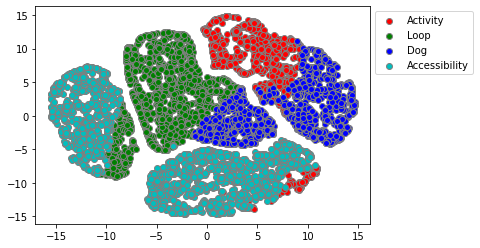

In [128]:
colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
data = group_1_tsne
target = group_1_labels.reshape(1,-1)[0]
target_names = ['Activity', 'Loop', 'Dog', 'Accessibility']
target_ids = np.unique(target)
plt.figure()
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(data[target == i, 0], data[target == i, 1],
                c=c, label=label, edgecolors='gray', alpha=1)
plt.legend(bbox_to_anchor=(1,1))

In [125]:
tsne = TSNE(n_components=2, n_iter=300, n_jobs=-1)
# group_2_tsne = tsne.fit_transform(group_2_dtm.todense())
group_2_tsne = tsne.fit_transform(hikes_df.iloc[group_2_idx[:,0]][['Topic_3', 'Topic_4', 'Topic_6', 'Topic_7', 'Topic_8']])

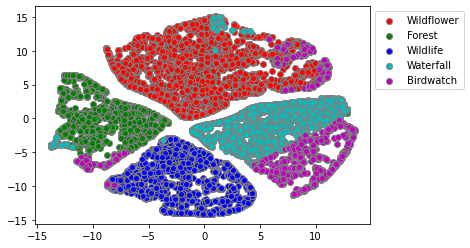

In [126]:
colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
data = group_2_tsne
target = group_2_labels.reshape(1,-1)[0]
target_names = ['Wildflower', 'Forest', 'Wildlife', 'Waterfall', 'Birdwatch']
target_ids = np.unique(target)
plt.figure()
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(data[target == i, 0], data[target == i, 1],
                c=c, label=label, edgecolors='gray', alpha=1)
plt.legend(bbox_to_anchor=(1,1))

In [11]:
tsne = TSNE(n_components=2, n_iter=300, n_jobs=-1)
t_results = tsne.fit_transform(X)

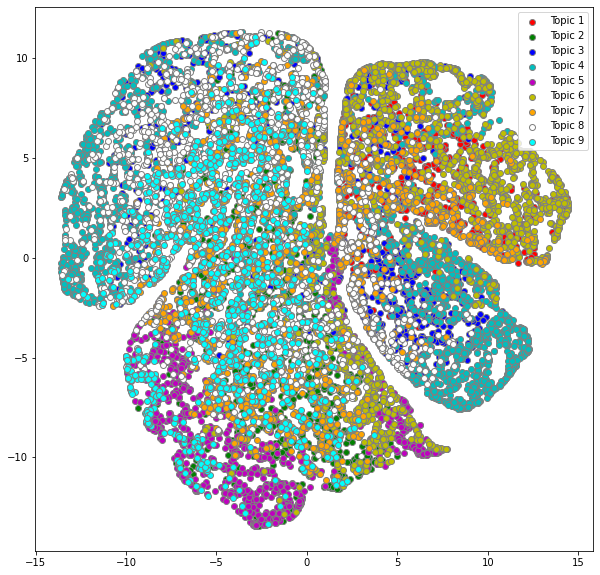

In [12]:
nlp_vis.plot_PCA_2D(t_results, y, ["Topic "+str(i) for i in range(1,10)])